# Least-squares technique

In [2]:
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, IntSlider

inv = np.linalg.inv

In [3]:
df = pd.read_csv('regression_data.csv')
df.head(3)

,x,y
0,0.047159,0.220033
1,0.064022,0.179399
2,0.080122,0.195405


## Population

0.5 and 0.2 are NOT the population parameters. Although we used them to generate the population, the population parameters can be different from them.

In [4]:
def get_y(x):
    ys =  x * 0.5 + 0.2
    noises = 1 * np.random.normal(size=len(ys))
    return ys + noises

In [5]:
np.random.seed(52)
xs = np.linspace(0, 10, 10000)
ys = get_y(xs)

np.random.seed(32)
np.random.shuffle(xs)
np.random.seed(32)
np.random.shuffle(ys)

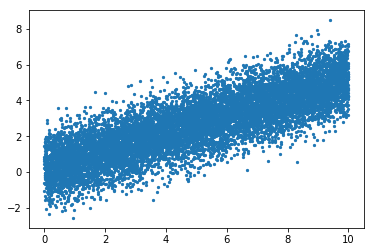

In [6]:
plt.scatter(xs, ys, s=5)
plt.show()

## Design matrices

In [7]:
PHI = xs.reshape(-1, 1)
PHI = np.hstack([
        PHI,
        np.ones(PHI.shape)
      ])
T = ys.reshape(-1, 1)

## Normal equation with regularization

In [8]:
def regularized_least_squares(PHI, T, regularizer=0):
    
    assert PHI.shape[0] == T.shape[0]
    
    pseudo_inv = inv(PHI.T @ PHI + np.eye(PHI.shape[1]) * regularizer)
    
    assert pseudo_inv.shape[0] == pseudo_inv.shape[1]
    
    W = pseudo_inv @ PHI.T @ T
    
    return {'slope' : float(W[0]), 'intercept' : float(W[1])}

## Sampling distributions

### Population parameters

In [9]:
pop_params = regularized_least_squares(PHI, T)

In [10]:
pop_slope, pop_intercept = pop_params['slope'], pop_params['intercept']

### Sample statistics

Verify that the sampling distribution for both regression coefficients are normal. 

In [109]:
n = 500  # sample size
num_samps = 1000

In [110]:
def sample(PHI, T, n):
    idxs = np.random.randint(PHI.shape[0], size=n)
    return PHI[idxs], T[idxs]

In [111]:
samp_slopes, samp_intercepts = [], []
for i in range(num_samps):
    PHI_samp, T_samp = sample(PHI, T, n)
    learned_param = regularized_least_squares(PHI_samp, T_samp)
    samp_slopes.append(learned_param['slope']); samp_intercepts.append(learned_param['intercept'])

In [112]:
np.std(samp_slopes), np.std(samp_intercepts)

(0.015135039160256712, 0.0884058558276644)

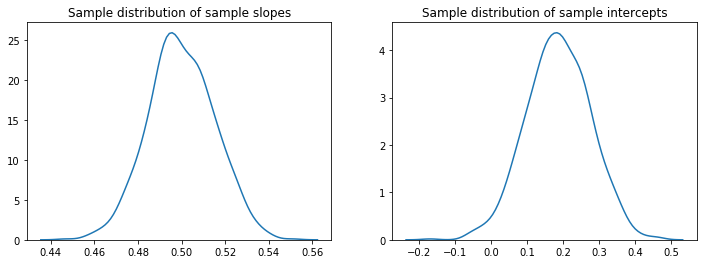

In [113]:
fig = plt.figure(figsize=(12, 4))

fig.add_subplot(121)
sns.kdeplot(samp_slopes)
plt.title('Sample distribution of sample slopes')

fig.add_subplot(122)
sns.kdeplot(samp_intercepts)
plt.title('Sample distribution of sample intercepts')

plt.show()

Note that the two normal distributions above are correlated. This means that we need to be careful when plotting the 95% CI for the regression line, because we can't just plot the regression line with the highest slope and the highest intercept.

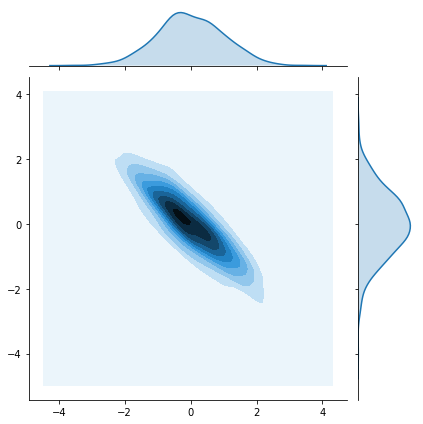

In [118]:
sns.jointplot(
    (np.array(samp_slopes) - pop_slope) / np.array(samp_slopes).std(), 
    (np.array(samp_intercepts) - pop_intercept) / np.array(samp_intercepts).std(), kind='kde')
plt.show()

## Confidence interval

**Caution.** The following computation of confidence intervals does not apply to regularized least squares.

### Sample one sample

In [73]:
n = 50
PHI_samp, T_samp = sample(PHI, T, n)

### Compute sample statistics

In [74]:
learned_param = regularized_least_squares(PHI_samp, T_samp)

In [75]:
samp_slope, samp_intercept = learned_param['slope'], learned_param['intercept']

In [76]:
samp_slope, samp_intercept

(0.5498817486738126, -0.2752686055302853)

### Compute standard errors of sample statistics

Standard error is the estimate of the standard deviation of the sampling distribution.

$$\hat\sigma = \sqrt{\frac{\text{Sum of all squared residuals}}{\text{Degrees of freedom}}}$$

Standard error for slope:
$$\text{SE}(\hat\beta_1)=\hat\sigma \sqrt{\frac{1}{(n-1)s_X^2}}$$

Standard error for intercept:

$$\text{SE}(\hat\beta_0)=\hat\sigma \sqrt{\frac{1}{n} + \frac{\bar X^2}{(n-1)s_X^2}}$$

where $\bar X$ is the sample mean of the $X$'s and $s_X^2$ is the sample variance of the $X$'s.

In [77]:
preds = samp_slope * PHI_samp[:,0] + samp_intercept
sum_of_squared_residuals = np.sum((T_samp.reshape(-1) - preds) ** 2)
samp_sigma_y_give_x = np.sqrt(sum_of_squared_residuals / (n - 2))

In [78]:
samp_sigma_y_give_x

1.054692556781874

In [79]:
samp_mean = np.mean(PHI_samp[:,0])
samp_var = np.var(PHI_samp[:,0])

In [80]:
SE_slope = samp_sigma_y_give_x * np.sqrt(1 / ((n - 1) * samp_var))
SE_intercept = samp_sigma_y_give_x * np.sqrt(1 / n + samp_mean ** 2 / ((n - 1) * samp_var))

In [81]:
SE_slope, SE_intercept

(0.053232440724134585, 0.3149357028871577)

### Compute confidence intervals for sample statistics

In [82]:
slope_lower, slope_upper = samp_slope - 1.96 * SE_slope, samp_slope + 1.96 * SE_slope
slope_lower, slope_upper

(0.44554616485450876, 0.6542173324931163)

In [83]:
intercept_lower, intercept_upper = samp_intercept - 1.96 * SE_intercept, samp_intercept + 1.96 * SE_intercept
intercept_lower, intercept_upper

(-0.8925425831891144, 0.34200537212854376)

### Translate confidence intervals for sample statistics to confidence interval for regression line

This section needs to take into account the correlation between sample slopes and sample intercepts.

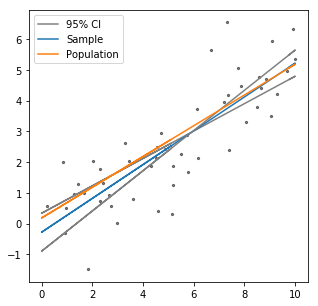

In [84]:
plt.figure(figsize=(5, 5))

plt.scatter(PHI_samp[:,0], T_samp, s=5, alpha=0.5, color='black')

plt.plot(xs, slope_lower * xs + intercept_upper, color='grey', label='95% CI')
plt.plot(xs, samp_slope  * xs + samp_intercept, label='Sample')
plt.plot(xs, slope_upper * xs + intercept_lower, color='grey')
plt.plot(xs, pop_slope   * xs + pop_intercept, label='Population')

plt.legend()
plt.show()

## Regularized least squares

In [373]:
def plot_regression_line(PHI, T, regularizer):
    
    plt.scatter(PHI[:,0], T, s=5)
    
    params = regularized_least_squares(PHI, T, regularizer)
    
    x_min, x_max = PHI[:,0].min(), PHI[:,0].max()
    xs = np.linspace(x_min, x_max, 2)
    ys = params['slope'] * xs + params['intercept']
    
    plt.plot(xs, ys, color='orange')
    
    plt.ylim(-3, 10)
    
    plt.show()

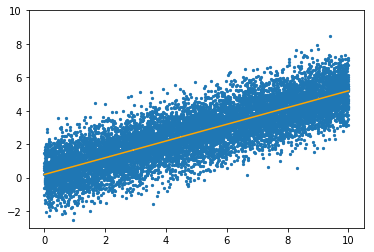

In [374]:
plot_regression_line(PHI, T, regularizer=20)

In [380]:
def plot_regression_line_wrapper(regularizer, num_points):
    plot_regression_line(PHI[:num_points], T[:num_points], regularizer)

Yes! The effect of regularization does change with the size of the dataset.

In [381]:
_ = interact(
    plot_regression_line_wrapper, 
    regularizer=IntSlider(min=0, max=10000, value=5000, continuous_update=False),
    num_points=IntSlider(min=2, max=1000, value=1000, continuous_update=False)
)

interactive(children=(IntSlider(value=5000, continuous_update=False, description='regularizer', max=10000), In…